<font size=6> <b> Week #4 : Visualization, Performance Measure </b> </font>
<div class="alert alert-block alert-success">
  Financial Data의 Interactive한 Visualization과 Prediction Measure를 알아보자!<br>
</div>
</div>

<p style="text-align:right;"> sumyeon@gmail.com </p>


<hr>

- 필요 모듈 import, 한글 폰트 로딩

> 필요 모듈 import

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

import datetime
import pandas_datareader.data as pdrdata
from tqdm.notebook import tqdm

#matplotlib inline

> 한글 폰트 로딩

In [3]:
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\\WINDOWS\\Fonts\\HYWULM.TTF').get_name()
plt.rc('font', family=font_name)

> supress annoying warnings

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=HessianInversionWarning)

<hr>

- 이전 학습 시간에 공유된 financial data loading 부분

In [5]:
metadf = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
metadf['종목코드'] = (metadf['종목코드'].apply(lambda x : f"{x:06}")).astype(str)
name2code_dict = dict(zip( metadf['회사명'].values, metadf['종목코드'].values))
code2name_dict = dict(zip( metadf['종목코드'].values, metadf['회사명'].values))

In [6]:
def getStockHistory(target, start='2019-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d')):
    """
    return the stock histories of the companies given
    
    Parameters:
        target   : str, int - a company name (str) or code (int)
        start    : str - start date string
        end      : str - end date string
        
    Returns:
        list : list of stock history data frame
    """
    
    # name <-> code 
    if isinstance(target, str) and not target.isnumeric():
        tickername = target
        ticker = name2code_dict[target]
    else:
        ticker = target
        tickername = code2name_dict[target]
        
    stockdf = pdrdata.DataReader(ticker, 'naver', start, end)
    for col in stockdf:
        stockdf[col] = stockdf[col].astype(int)
    stockdf = stockdf.assign(tickername=tickername, tickercode=ticker)
    return stockdf

In [7]:
getStockHistory("삼성전자", start='2022-01-01')

,Open,High,Low,Close,Volume,tickername,tickercode
Date,,,,,,,
2022-01-03,79400,79800,78200,78600,13502112,삼성전자,005930
2022-01-04,78800,79200,78300,78700,12427416,삼성전자,005930
2022-01-05,78800,79000,76400,77400,25470640,삼성전자,005930
2022-01-06,76700,77600,76600,76900,12931954,삼성전자,005930
2022-01-07,78100,78400,77400,78300,15163757,삼성전자,005930
...,...,...,...,...,...,...,...
2022-06-17,59400,59900,59400,59800,29053450,삼성전자,005930
2022-06-20,59800,59900,58100,58700,34111306,삼성전자,005930
2022-06-21,58700,59200,58200,58500,25148109,삼성전자,005930


<hr>

# 금융 데이터 챠트를 그려보자

## pandas 챠트 그려보기 

In [8]:
name = "두산퓨얼셀"

In [9]:
stockdf = getStockHistory(name, start='2019-01-01')

<AxesSubplot:xlabel='Date'>

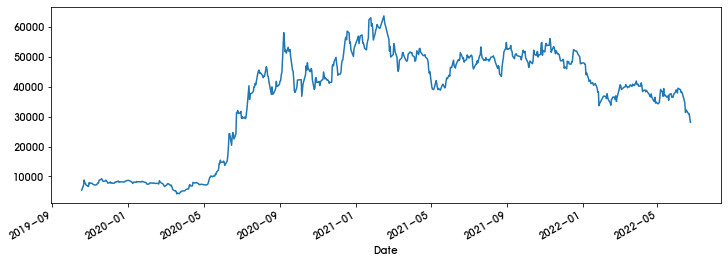

In [10]:
stockdf['Close'].plot(figsize=(12,4))

## 회사 챠트 만들기 - 자유롭게 회사 선택

- ipywidget을 활용해서 interactive하게 종목과 날짜를 바꾸어 볼 수 있는 그래프 그리기

> widgets은 ipython(jupyter)에 interactive한 요소를 추가 해주는 기능

In [11]:
import ipywidgets as widgets

> <b> 실제 그래프를 표시할 함수 만들기 </b> <br>
> widget에서 리턴되는 내용들이 argument가 되어, 수행하는 함수 만들기. widget값이 바뀔 경우 함수가 자동 재수행됨

In [12]:
def draw_chart(ticker, date_range, values):
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    stockdf = getStockHistory(ticker, date_range[0].strftime("%Y-%m-%d"), date_range[1].strftime("%Y-%m-%d"))
    stockdf = stockdf.resample('D').fillna('ffill')
    stockdf[list(values)].plot(ax=ax)

    xtick = pd.date_range(start=stockdf.index.min( ), end=stockdf.index.max( ), freq='W' )
    ax.set_xticks( xtick, minor=True )
    ax.grid('on', which='minor', axis='x' )
    ax.grid('on', which='major', axis='x' )

> <b> 표시 기간/날짜를 선택하는 widget 만들기 </b> <br>
> 먼저, 전체 기간의 시작과 끝을 정하고, 해당 기간을 선택할 option으로 만들어 제공하면 선택 결과가 tuple로 return됨

In [13]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime.now().date()
dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

> <b> 표시할 내용 선택 widget 만들기 </b> <br>
> 여러 값들 중에서 선택한 내용이 리스트로 전달됨. 복수 선택 가능

In [14]:
selection_values = widgets.SelectMultiple(
    options=['Open','Close','High','Low'],
    value=['Close'],
    description='Values',
    disabled=False
)

> <b> widgets.ineract를 통해 interactive한 함수 기능 제공 </b> <br>
> 준비해둔 widget과 함수를 연결해주는 내용

In [16]:
ticker_candidate = ['삼성전자','두산퓨얼셀','LG에너지솔루션']
widgets.interact(draw_chart, ticker=ticker_candidate , date_range=selection_range_slider, values=selection_values)

interactive(children=(Dropdown(description='ticker', options=('삼성전자', '두산퓨얼셀', 'LG에너지솔루션'), value='삼성전자'), Sel…

<function __main__.draw_chart(ticker, date_range, values)>

<div class="alert alert-block alert-info">
<b> Tip:</b> draw_chart 함수를 개선해서, 거래량을 추가하거나 또는 두 개 이상의 회사 챠트를 그리는 것 도 가능 </b> <br>
=> 나만의 주가 대시보드를 만들어보는 프로젝트도 가능!!
</div>

<hr>

# Financial Data Prediction 

## prediction algorithm template

- OHLCV (Open-High-Low-Close-Volume)를 사용해서 매수/매도를 추천

- Stock Data라는 가정하에 추천된 매수/매도에 맞추어 투자를 하고 그 결과를 가지고 알고리즘을 평가

# Reference Algorithm 
> 미래를 미리 알고 있어 정확한 투자를 할 수 있는 알고리즘을 레퍼런스(비교) 알고리즘으로 상정 <br>
> 구체적으로는 (3일 연속) 상승이 예상되면 매수 후 가격 하락이 시작되기 직전 매도 <br>> 
suboptimal : 미래의 급등락을 정확하게 맞출 수 있으므로 비교 가능한 상황에서는 거의 최고 성능의 알고리즘

 - 주식 정보를 가져오자 <br>
 

In [17]:
name = "삼성전자"
stockdf = getStockHistory(name, start='2019-01-01')

In [18]:
stockdf[:10]

,Open,High,Low,Close,Volume,tickername,tickercode
Date,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,삼성전자,005930
2019-01-03,38300,38550,37450,37600,12471493,삼성전자,005930
2019-01-04,37450,37600,36850,37450,14108958,삼성전자,005930
2019-01-07,38000,38900,37800,38750,12748997,삼성전자,005930
2019-01-08,38000,39200,37950,38100,12756554,삼성전자,005930
2019-01-09,38650,39600,38300,39600,17452708,삼성전자,005930
2019-01-10,40000,40150,39600,39800,14731699,삼성전자,005930
2019-01-11,40350,40550,39950,40500,11661063,삼성전자,005930
2019-01-14,40450,40700,39850,40050,11984996,삼성전자,005930


 - 주식 정보는 토/일, 휴일이 missing되어 있으므로, time-series 분석을 위해 토/일요일 정보를 forward fill 방식으로 채우자

In [19]:
stockdf= stockdf.resample('D').fillna('ffill')

In [20]:
stockdf[:10]

,Open,High,Low,Close,Volume,tickername,tickercode
Date,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,삼성전자,005930
2019-01-03,38300,38550,37450,37600,12471493,삼성전자,005930
2019-01-04,37450,37600,36850,37450,14108958,삼성전자,005930
2019-01-05,37450,37600,36850,37450,14108958,삼성전자,005930
2019-01-06,37450,37600,36850,37450,14108958,삼성전자,005930
2019-01-07,38000,38900,37800,38750,12748997,삼성전자,005930
2019-01-08,38000,39200,37950,38100,12756554,삼성전자,005930
2019-01-09,38650,39600,38300,39600,17452708,삼성전자,005930
2019-01-10,40000,40150,39600,39800,14731699,삼성전자,005930


 - 종가 기준으로 내일 증가량과 그 증감 ratio를 계산해 두자

In [21]:
tdf = stockdf

In [22]:
tdf['tomorrow_delta'] = tdf['Close'].shift(-1) - tdf['Close']   # 내일의 주가를 가져와 오늘의 주가와 차이름 추출
tdf['tomorrow_ratio'] = tdf['tomorrow_delta'] / tdf['Close'] * 100 # 오늘의 주가 대비, 내일의 증가량을 확인

In [23]:
tdf.head()

,Open,High,Low,Close,Volume,tickername,tickercode,tomorrow_delta,tomorrow_ratio
Date,,,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,삼성전자,005930,-1150.0,-2.967742
2019-01-03,38300,38550,37450,37600,12471493,삼성전자,005930,-150.0,-0.398936
2019-01-04,37450,37600,36850,37450,14108958,삼성전자,005930,0.0,0.000000
2019-01-05,37450,37600,36850,37450,14108958,삼성전자,005930,0.0,0.000000
2019-01-06,37450,37600,36850,37450,14108958,삼성전자,005930,1300.0,3.471295


<div class="alert alert-block alert-info">
<b> Tip:</b> Pandas의 pct_change 함수를 이용해서 한번에 증감 정보를 계산하는 것도 가능! <br> <br>
<pre>
tdf['tomorrow_ratio'] = tdf['Close'].pct_change().shift(-1)
</pre>
</div>

 - 핵심 알고리즘 구현 : 3일 이상 계속 상승하면 매수! 가격이 꺽이는 날 직전에 매도!!

In [24]:
invest_list = []
during_invest = False

# 주가를 하루 하루 날짜별로 쫒아 가보자
for index, row in tdf[:-1].iterrows():
    if row['tomorrow_delta'] < 0 and during_invest:               
        invest.append(index)  # set the date as "end day of invest"
        during_invest = False
        if (invest[1] - invest[0]).days >= 3:
            invest_list.append(invest)
    elif row['tomorrow_delta'] < 0 and not during_invest:
        continue
    elif row['tomorrow_delta'] > 0 and during_invest:
        continue
    elif row['tomorrow_delta'] > 0 and not during_invest:
        invest = [index]
        during_invest = True

invest_list[-10:]

[[Timestamp('2022-01-27 00:00:00', freq='D'),
  Timestamp('2022-02-06 00:00:00', freq='D')],
 [Timestamp('2022-02-07 00:00:00', freq='D'),
  Timestamp('2022-02-10 00:00:00', freq='D')],
 [Timestamp('2022-02-24 00:00:00', freq='D'),
  Timestamp('2022-03-01 00:00:00', freq='D')],
 [Timestamp('2022-04-17 00:00:00', freq='D'),
  Timestamp('2022-04-21 00:00:00', freq='D')],
 [Timestamp('2022-04-28 00:00:00', freq='D'),
  Timestamp('2022-05-01 00:00:00', freq='D')],
 [Timestamp('2022-05-02 00:00:00', freq='D'),
  Timestamp('2022-05-05 00:00:00', freq='D')],
 [Timestamp('2022-05-12 00:00:00', freq='D'),
  Timestamp('2022-05-15 00:00:00', freq='D')],
 [Timestamp('2022-05-19 00:00:00', freq='D'),
  Timestamp('2022-05-22 00:00:00', freq='D')],
 [Timestamp('2022-05-26 00:00:00', freq='D'),
  Timestamp('2022-05-30 00:00:00', freq='D')],
 [Timestamp('2022-06-02 00:00:00', freq='D'),
  Timestamp('2022-06-06 00:00:00', freq='D')]]

## 비교 (레퍼런스) 알고리즘 end-to-end 모듈화 (함수화)

In [25]:
def realistic_optimal(targetdf, min_investdays=3, start_invest_date = datetime.date(2022,6,1)):
    
    targetdf= targetdf.resample('D').fillna('ffill')
    targetdf = targetdf.loc[start_invest_date:,]
    tdf = targetdf[['Close']].copy(deep=True)
    tdf['tomorrow_delta'] = tdf['Close'].shift(-1) - tdf['Close'] 
    tdf['tomorrow_ratio'] = tdf['tomorrow_delta'] / tdf['Close'] * 100
    
    invest_list = []
    during_invest = False
    for index, row in tdf[:-1].iterrows():
        if row['tomorrow_delta'] < 0 and during_invest:               
            invest.append(index)  # set the date as "end day of invest"
            during_invest = False
            if (invest[1] - invest[0]).days >= 3:
                invest_list.append(invest)
        elif row['tomorrow_delta'] < 0 and not during_invest:
            continue
        elif row['tomorrow_delta'] > 0 and during_invest:
            continue
        elif row['tomorrow_delta'] > 0 and not during_invest:
            invest = [index]
            during_invest = True
            
    return invest_list

In [26]:
realistic_optimal(stockdf)

[[Timestamp('2022-06-02 00:00:00', freq='D'),
  Timestamp('2022-06-06 00:00:00', freq='D')]]

## 비교 알고리즘을 평가해 보자!

### prediction algorithm (practical) evaluation

 - 알고리즘의 결과물로 (매수일자,매도일자) 튜플 리스트를 받아, (Close 종가 대비) 투자 결과를 measure로 사용
 - 최종 성능 평가는 (최종 보유 금액) / (첫 보유 금액)을 %로 출력

In [27]:
def measure_stock_invest_gains(tdf, invest_list, seed_money=5_000_000, commision_perc=0.2, start_ts=None, end_ts=None):
    
    invest_money = seed_money
    tdf= tdf.resample('D').fillna('ffill')
    for [buy_date,sell_date] in invest_list:
        buy_price = tdf.loc[buy_date, 'Close']
        stock_amount = invest_money // buy_price
        remain_money = invest_money - stock_amount * buy_price
        sell_price = tdf.loc[sell_date, 'Close']
        invest_money = stock_amount * sell_price * (100-commision_perc)/100 + remain_money
        #print(f"{buy_price} - {sell_price}")
        
    if start_ts is None or end_ts is None:
        start_ts, end_ts = tdf.index[0], tdf.index[-1]
    
    total_earn_ratio = (invest_money - seed_money) / seed_money * 100.0
    daily_earn_ratio = total_earn_ratio / ((end_ts - start_ts).days+1)
    return total_earn_ratio, daily_earn_ratio

In [28]:
invest_list = realistic_optimal(stockdf)

In [29]:
total_earn_ratio, daily_earn_ratio = measure_stock_invest_gains(stockdf, invest_list, start_ts=invest_list[0][0], end_ts=invest_list[-1][1])

print(f"The total earn ratio is {total_earn_ratio:.1f}%, daily earn ratio is {daily_earn_ratio:.1f}% !!")

The total earn ratio is -0.0%, daily earn ratio is -0.0% !!


# 알고리즘 Visualization
> 전체 챠트에서, 투자 기간 (매수/매도) 기간을 표시

In [30]:
import matplotlib
matplotlib.style.use('ggplot')

In [31]:
def visualize_invest(targetdf, invest_list):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    
    # draw whole graph
    targetdf= targetdf.resample('D').fillna('ffill')
    tdf = targetdf[['Close']]
    tdf['Close'].plot(ax=ax, color='yellow', linewidth=2)
    
    #plt.scatter(targetdf.index, targetdf['Close'], color='Black')
    
    
    #draw invest graph
    for [sdate,edate] in invest_list:
        tdf.loc[sdate:edate,'Close'].plot(ax=ax, color='green', linewidth=4, alpha=0.6)

        

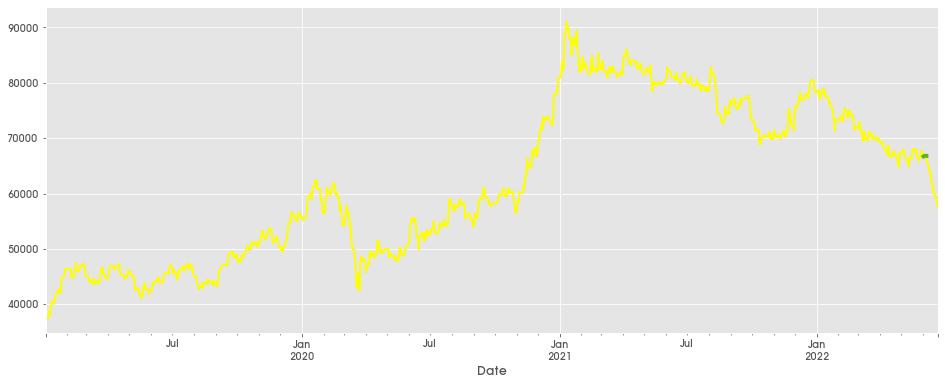

In [32]:
visualize_invest(stockdf, invest_list)

<hr>

<div class="alert alert-block alert-warning">
<b> ARIMA를 통한 forecast가 주가를 잘 따르는 것으로 보일 수도 있지만, 자세히 보면 다음날 주가의 등/락을 반대로 예측하는 경우가 있음
</div>

# ARIMA 모델을 적용한 주식 투자 모델을 만들어 보자

- referenc 투자 모델은, 시세를 따라가면서 주가가 3일 연속 증가할 것으로 예측되면 매수를, 바로 하락이 예상되는 시점에 매도를 한다!<br>

- ARIMA 모델은, reference 투자 모델과 동일한 형태이나 실제 값이 아닌 ARIMA_forecast 값을 바탕으로 결정을 내림

- 참고) ARIMA model의 forecast 함수를 활용. steps=N argument를 통해 N 개의 미래값을 예측 <br>

## 샘플용 데이터 확보

In [33]:
stockdf = getStockHistory("삼성전자", start='2022-01-01')
stockdf= stockdf.resample('D').fillna('ffill')

In [34]:
stockdf

,Open,High,Low,Close,Volume,tickername,tickercode
Date,,,,,,,
2022-01-03,79400,79800,78200,78600,13502112,삼성전자,005930
2022-01-04,78800,79200,78300,78700,12427416,삼성전자,005930
2022-01-05,78800,79000,76400,77400,25470640,삼성전자,005930
2022-01-06,76700,77600,76600,76900,12931954,삼성전자,005930
2022-01-07,78100,78400,77400,78300,15163757,삼성전자,005930
...,...,...,...,...,...,...,...
2022-06-19,59400,59900,59400,59800,29053450,삼성전자,005930
2022-06-20,59800,59900,58100,58700,34111306,삼성전자,005930
2022-06-21,58700,59200,58200,58500,25148109,삼성전자,005930


## ARIMA Rolling Window Fit 알고리즘을 활용한 투자 함수

In [41]:
def arima_rolling_window_invest(targetdf, min_investdays = 3, start_invest_date = datetime.date(2022,6,1)):
    
    tdf = targetdf[['Close']].copy(deep=True)
    tdf = tdf[['Close']]   
    invest_list = []
    during_invest = False
    
    train = tdf.loc[:start_invest_date, 'Close']
    test = tdf.loc[start_invest_date:, 'Close']
    history = [ x for x in train]

    for t in tqdm(range(len(test)), position=0, leave=True):
        model = ARIMA(history, order=(2,1,2))
        model_fit = model.fit();
        forecast_vals = model_fit.forecast(steps=min_investdays)
        
        obs = test[t]
        base_forecast = np.insert(forecast_vals, 0, obs)
        history.append(obs)

        if during_invest and ((base_forecast[1] < base_forecast[0]) or (base_forecast[0] < buy_price)):
            invest.append(test.index[t])  # set today as end date of invest
            during_invest = False
            invest_list.append(invest)
            #print("--", base_forecast, test.index[t])
        elif base_forecast[1] < base_forecast[0] and not during_invest:
            continue
        elif base_forecast[1] - base_forecast[0] > 0 and during_invest:
            continue
        elif np.all(np.diff(base_forecast) > 0) and not during_invest:
            invest = [test.index[t]]
            during_invest = True
            buy_price = obs
            buy_index = t
            #print("++", base_forecast, test.index[t])
            
    return invest_list

## 투자 예측 결과

In [42]:
invest_list = arima_rolling_window_invest(stockdf, min_investdays = 3, start_invest_date='2022-06-01')

  0%|          | 0/23 [00:00<?, ?it/s]

C:\Program Files\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
invest_list

[[Timestamp('2022-06-08 00:00:00', freq='D'),
  Timestamp('2022-06-09 00:00:00', freq='D')],
 [Timestamp('2022-06-14 00:00:00', freq='D'),
  Timestamp('2022-06-15 00:00:00', freq='D')],
 [Timestamp('2022-06-21 00:00:00', freq='D'),
  Timestamp('2022-06-22 00:00:00', freq='D')]]

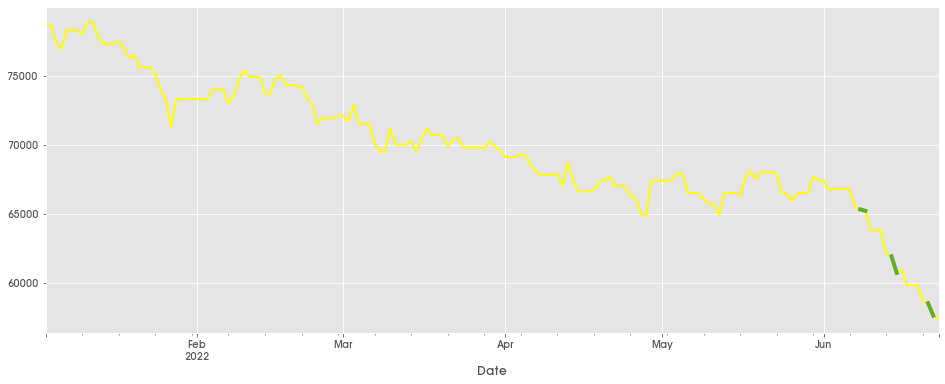

In [44]:
visualize_invest(stockdf[datetime.datetime(2022,1,1):], invest_list)

<div class="alert alert-block alert-info">
<b> Tip:</b> 노란색이 주가 변화를, 녹색으로 나타난 부분이 매입/매도 구간을 나타냄
</div>

## Reference 투자 알고리즘과 비교

In [45]:
measure_stock_invest_gains(stockdf, invest_list)

(-4.14968, -0.02412604651162791)

In [46]:
measure_stock_invest_gains(stockdf, realistic_optimal(stockdf.loc[datetime.datetime(2022,6,1):]) )

(-0.04972800000000745, -0.00028911627906981073)

In [47]:
realistic_optimal(stockdf.loc[datetime.datetime(2022,6,1):])

[[Timestamp('2022-06-02 00:00:00', freq='D'),
  Timestamp('2022-06-06 00:00:00', freq='D')]]

# Wrapup

## 앞서 작성한 챠트 그래프에 투자 정보를 입혀 보자!
> 앞에서 사용한 추가적인 코드 필요 없음

- ipywidget을 활용해서 interactive하게 종목과 날짜를 바꾸어 볼 수 있는 그래프 그리기

> widgets은 ipython(jupyter)에 interactive한 요소를 추가 해주는 기능

In [48]:
import ipywidgets as widgets

> <b> 실제 그래프를 표시할 함수 만들기 </b> <br>
> widget에서 리턴되는 내용들이 argument가 되어, 수행하는 함수 만들기. widget값이 바뀔 경우 함수가 자동 재수행됨

In [49]:
def draw_chart(ticker, date_range, values, invest_alg):
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    stockdf = getStockHistory(ticker, date_range[0].strftime("%Y-%m-%d"), date_range[1].strftime("%Y-%m-%d"))
    stockdf = stockdf.resample('D').fillna('ffill')
    stockdf[list(values)].plot(ax=ax)
    
    # draw invest 
    if invest_alg is not None:
        invest_list = invest_alg(stockdf)
        for [sdate,edate] in invest_list:
            stockdf.loc[sdate:edate,'Close'].plot(ax=ax, color='yellow', linewidth=4, alpha=0.9 )
            
    total_earn_ratio, daily_earn_ratio = measure_stock_invest_gains(stockdf, invest_list, start_ts=datetime.datetime(2022,6,1), end_ts=stockdf.index[-1])
    print(f"The total earn ratio is {total_earn_ratio:.1f}%, daily earn ratio is {daily_earn_ratio:.1f}% !!")

    xtick = pd.date_range(start=stockdf.index.min( ), end=stockdf.index.max( ), freq='W' )
    ax.set_xticks( xtick, minor=True )
    ax.grid('on', which='minor', axis='x' )
    ax.grid('on', which='major', axis='x' )

> <b> 표시 기간/날짜를 선택하는 widget 만들기 </b> <br>
> 먼저, 전체 기간의 시작과 끝을 정하고, 해당 기간을 선택할 option으로 만들어 제공하면 선택 결과가 tuple로 return됨

In [50]:
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime.now().date()
dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

> <b> 표시할 내용 선택 widget 만들기 </b> <br>
> 여러 값들 중에서 선택한 내용이 리스트로 전달됨. 복수 선택 가능

In [51]:
selection_values = widgets.SelectMultiple(
    options=['Open','Close','High','Low'],
    value=['Close'],
    description='Values',
    disabled=False
)

> <b> widgets.ineract를 통해 interactive한 함수 기능 제공 </b> <br>
> 준비해둔 widget과 함수를 연결해주는 내용

In [52]:
ticker_candidate = ['삼성전자','LG에너지솔루션']
alg_candidate = [arima_rolling_window_invest, realistic_optimal]
widgets.interact(draw_chart, ticker=ticker_candidate , date_range=selection_range_slider, values=selection_values, invest_alg=alg_candidate)

interactive(children=(Dropdown(description='ticker', options=('삼성전자', 'LG에너지솔루션'), value='삼성전자'), SelectionRan…

<function __main__.draw_chart(ticker, date_range, values, invest_alg)>

<div class="alert alert-block alert-info">
<b> Tip:</b> draw_chart 함수를 개선해서, 거래량을 추가하거나 또는 두 개 이상의 회사 챠트를 그리는 것 도 가능 </b> <br>
=> 나만의 주가 대시보드를 만들어보는 프로젝트도 가능!!
</div>

<img src="https://miro.medium.com/max/517/1*9xhiP7nD8Ur2c3nrnApQkQ.jpeg">